In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string
import time, datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
glove_model = KeyedVectors.load_word2vec_format('glove.6B.50d.txt')

In [5]:
def embed(documents: list[str]):  
    # return the document embeddings
    docembeds = []
    for doc in documents:
      embeddings = []
      doc = [x.lower() for x in doc.split()]
      for word in doc:
        if word in glove_model.key_to_index:
          embeddings.append(glove_model[word])
        else:
          embeddings.append(np.zeros(50, dtype = np.float32))
      docembeds.append(np.mean(embeddings, axis =0))
    return np.array(docembeds)

In [6]:
emb = embed(["I like goats"])
print(emb.shape) # expecting (1, 50)
emb = embed(["I like goats", "I hate pizza"])
print(emb.shape) # expecting (2, 50)

(1, 50)
(2, 50)


In [7]:
# read the dataset into a pandas dataframe. (it's likely in the file tweets.csv)
df = pd.read_csv("tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df.loc[:, ["text", "airline_sentiment"]]
replacement = {"negative": 0, "neutral": 1, "positive": 2}
df["airline_sentiment"] = df["airline_sentiment"].replace(replacement)
df.head()


/var/folders/gp/11kjzrl561d8g_nm5m8y6cz80000gn/T/ipykernel_89254/1366292700.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["airline_sentiment"] = df["airline_sentiment"].replace(replacement)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [9]:
# embed the tweets and store the embeddings in a new column

df["embeddings"] = list(embed(df["text"]))
df.head()

,text,airline_sentiment,embeddings
0,@VirginAmerica What @dhepburn said.,1,"[-0.082155, -0.29689726, -0.122389995, -0.1452..."
1,@VirginAmerica plus you've added commercials t...,2,"[0.06298155, 0.109819666, 0.10805444, 0.087568..."
2,@VirginAmerica I didn't today... Must mean I n...,1,"[0.23946483, 0.07386292, 0.10928809, -0.270529..."
3,@VirginAmerica it's really aggressive to blast...,0,"[0.24487439, -0.0802984, -0.016009405, -0.0927..."
4,@VirginAmerica and it's a really big bad thing...,0,"[0.14809425, 0.069789, -0.073238805, -0.088518..."


In [10]:
# set the random_state to 42 so the results are reproducible
# Use a 80/20 split for train/test

train_data, test_data = train_test_split(df,random_state = 42, test_size = 0.20 )

In [11]:
# extract the embedding and sentiment columns from the train and test dataframes as numpy arrays
# and store them as train_x, train_y, val_x, val_y

train_x, train_y = train_data["embeddings"], train_data["airline_sentiment"]
val_x, val_y = test_data["embeddings"], test_data["airline_sentiment"]

In [12]:
# use TensorDataset from torch to create train and validation datasets
tensor_trainx = torch.tensor(list(train_x))
tensor_trainy = torch.tensor(list(train_y))

tensor_valx = torch.tensor(list(val_x))
tensor_valy = torch.tensor(list(val_y))

datasetTrain = TensorDataset(tensor_trainx, tensor_trainy)
datasetVal = TensorDataset(tensor_valx, tensor_valy)


# use DataLoader from torch to create train and validation dataloaders
dataloader_train = DataLoader(datasetTrain)
dataloader_val = DataLoader(datasetVal)


/var/folders/gp/11kjzrl561d8g_nm5m8y6cz80000gn/T/ipykernel_89254/4267352700.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  tensor_trainx = torch.tensor(list(train_x))


In [33]:
class MLP(nn.Module):
  def __init__(self, layer_sizes):
    super(MLP, self).__init__()
    li = []
    for i in range(len(layer_sizes)-1):
      li.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
      if i < len(layer_sizes) - 2:
          li.append(nn.ReLU())
          li.append(nn.Dropout(0.1))
    self.model = nn.Sequential(*li)
  def forward(self,x):
    return self.model(x)

In [23]:
def train_one_epoch(model, criterion, train_loader, optimizer):
    model.train()

    running_loss = 0
    num_correct = 0
    num_samples = 0

    for inputs, targets in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()


        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        num_correct += (outputs.argmax(dim=1) == targets).sum().item()
        num_samples += batch_size

    avg_loss = running_loss / max(num_samples, 1)
    acc = num_correct / max(num_samples, 1)
    return acc, avg_loss


In [24]:
def validate(model, val_loader, criterion):

    model.eval()

    running_loss = 0
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            batch_size = targets.size(0)
            running_loss += loss.item() * batch_size
            num_correct += (outputs.argmax(dim=1) == targets).sum().item()
            num_samples += batch_size

    avg_loss = running_loss / max(num_samples, 1)
    acc = num_correct / max(num_samples, 1)
    return acc, avg_loss


In [25]:
import torch.optim as optim

In [26]:
def train(model, train_loader, val_loader, epochs):

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
    best_acc = 0.0
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }


    start_time = time.time()
    pbar = tqdm(range(epochs))

    for epoch in pbar:
        train_acc1, train_loss = train_one_epoch(model,criterion, train_loader, optimizer)

        val_acc1, val_loss = validate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc1)
        history["val_acc"].append(val_acc1)

        best_acc = max(val_acc1, best_acc)

        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, train_acc=train_acc1, val_acc=val_acc1)



    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('=' * 50)
    print(f'Training time {total_time_str}')
    print(f'Max accuracy {best_acc:.4f}')
    print('=' * 50)

    return history, best_acc

In [34]:
input_dim = 50

model = MLP([input_dim, 512, 256, 128, 64, 3])

history, best_acc = train(model, dataloader_train, dataloader_val, 10)

100%|██████████| 10/10 [03:36<00:00, 21.60s/it, train_acc=0.732, train_loss=0.673, val_acc=0.724, val_loss=0.717]

Training time 0:03:36
Max accuracy 0.7319


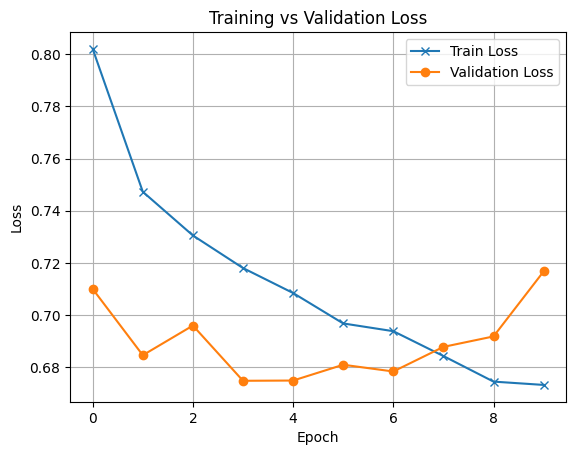

In [35]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss", marker="x")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

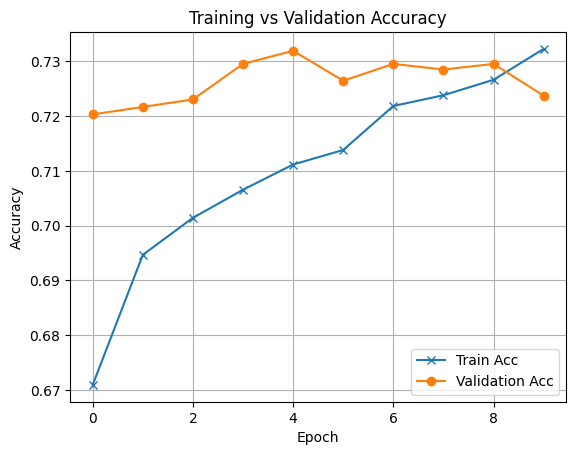

In [36]:
plt.figure()
plt.plot(history["train_acc"], label="Train Acc", marker="x")
plt.plot(history["val_acc"], label="Validation Acc", marker="o")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Evaluating!

In [37]:
text = "From boarding to landing, the whole process was quite upsetting."

embedding = torch.tensor(embed([text]))

model.eval()
softmax = nn.Softmax(dim=1)

with torch.no_grad():
    output = model(embedding)
    probs = softmax(output)
    pred = torch.argmax(probs, dim=1).item()

labels = {0: "negative", 1: "neutral", 2: "positive"}
result = labels[pred]

print(f"Text: {text}")
print(f"Predicted sentiment: {result}")

Text: From boarding to landing, the whole process was quite upsetting.
Predicted sentiment: negative
